# Strojové učenie



#### Použité knižnice

In [1]:
import pandas as pd
from IDA_utils import *
from scipy.stats import shapiro, kstest
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

#### Predpríprava dát

- Najskôr je nutné načítať zdrojové súbory do Pandas datasetov. Následne sa môžme vysporiadať s __nešpecifikovanými hodnotami__ a __vychýlenými hodnotami__. Budeme postupovať rovnako ako v minulej fáze, použijeme funkcie zo súboru __IDA_utils.py__.
- Ďalej je vhodné rozdeliť si dáta na __trénovací__ a __testovací dataset__ pomocou funcie *split_data()*. Ďalej budeme pracovať iba s trénovacími datasetmi.

In [2]:
PRODUCT_FILE_PATH = "resources/product.csv"
USER_FILE_PATH = "resources/user.csv"
SESSION_FILE_PATH = "resources/session.csv"

prod_df = pd.read_csv(PRODUCT_FILE_PATH, delimiter='\t')
user_df = pd.read_csv(USER_FILE_PATH, delimiter='\t')
sess_df = pd.read_csv(SESSION_FILE_PATH, delimiter='\t')

# this function is imported from IDA_utils.py
process_missing_vals(prod_df)
process_missing_vals(user_df)
process_missing_vals(sess_df)

process_outliers(prod_df)
process_outliers(user_df)
process_outliers(sess_df)

prod_train_df, prod_test_df = split_data(prod_df, 0.8)
user_train_df, user_test_df = split_data(user_df, 0.8)
sess_train_df, sess_test_df = split_data(sess_df, 0.8)

NaN count before - 22, after - 0
NaN count before - 380, after - 0
NaN count before - 1773, after - 0
NaN count before - 127, after - 0
NaN count before - 1266, after - 0
NaN count before - 1140, after - 0
NaN count before - 1520, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 10, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0
NaN count before - 11, after - 0


## Jednoduchý klasifikátor na základe závislostí v dátach

- V tejto časti implementujeme jednoduchý __OneR algoritmus__, ktorý nám s určitou presnosťou klasifikuje výsledok skúmaného atribútu pri jednotlivých __prediktoroch__. Celková funkcionalita je implementovaná pomocou nasledovných funkcií:
    
    a) *frequency_tables()*
    
    b) *one_rule_alg()*

- Prvá z funkcií vracia pre jednotlivé prediktory __tabuľky frekvencií__ vo vzťahu so skúmaných atribútom. V podstate ide o zoskupenie všetkých unikátnych hodnôt konkrétneho prediktora a uvedenie ich počtov. Výsledok je vrátený ako __mapa__, kde kľúče sú názvy prediktorov a hodnoty samotné tabuľky. Druhá funkcia akceptuje ako parameter takúto mapu, kde pre každý prediktor určí pravidlo, či platí hodnota A alebo B a s akou presnosťou to možno určiť.

In [3]:
def frequency_tables(df: pd.DataFrame, target_column: str, predictors: tuple[str]):
    if len(predictors) == 0:
        raise ValueError("At least one predictor needed!")

    result = {}

    for predictor in predictors:
        # here we use crosstab utility to get all the predictor value counts in combination with target column's
        freq_table = pd.crosstab(df[predictor], df[target_column])
        result[predictor] = freq_table

    return result


def one_rule_alg(freq_tables: Dict[str, pd.DataFrame], metric: Literal['accuracy', 'precision', 'recall'] = 'accuracy'):
    accuracies = {}
    rules = {}

    for table in freq_tables:

        #confusion matrix
        positive = [0, 0]
        negative = [0, 0]

        #here we iterate over all rows and according to their counts for ACK=1 or ACK = 0, we add it the positive or negative
        for index, row in freq_tables[table].iterrows():

            row_vals = row.items()
            row_vals = list(row_vals) 

            # if number of counts for ack = 1 > ack = 0, we add the values to the upper row of confusion matrix
            # at the same time we create a rule for the specific predictor, for instance if pct_input = 5, then ACK = 1
            if row_vals[0][1] > row_vals[1][1]:
                rules[table] = freq_tables[table].columns[0]
                positive[0] +=  row_vals[0][1]
                positive[1] += row_vals[1][1]
            #otherwise we do the opposite
            else:
                rules[table] = freq_tables[table].columns[1]
                negative[0] +=  row_vals[0][1]
                negative[1] += row_vals[1][1]
        
        # here we use data from the confusion matrix in a formula used for the selected metric
        try:
            if metric == 'accuracy':
                accuracies[table] = ((positive[0] + negative[1])/(positive[0] + positive[1] + negative[0] + negative[1]))
            elif metric == 'precision':
                accuracies[table] = ((positive[0])/(positive[0] + positive[1]))
            elif metric == 'recall':
                accuracies[table] = ((positive[0])/(positive[0] + negative[0]))
        # this mainly happens in precision, when there are no predictors for ACK = 1
        except ZeroDivisionError:
            accuracies[table] = -1
            
    return rules, accuracies, {'used_metric': metric}

- Teraz, keď máme algoritmus implementovaný, môžeme ho ísť otestovať na zvolenom __testovacom atribúte__ a na __prediktoroch__. V prípade tohto algoritmu sú pravidlá binárne, platí buď hodnota A testovaného atribútu alebo B. Preto sme sa rozhodli zvoliť si atribút __ack__ v datasete __sess_train_df__ a budeme skúmať, s akou presnosťou by sa stroj rozhodol pre klasifikáciu ďalšieho sedenia na __kúpu__ (ACK=0) či __nekúpu__ (ACK=1). Teraz aplikujeme algoritmus na všetky atribúty, o ktorých má zmysel uvažovať ako o možných prediktoroch - vylúčime __ID atribúty__.
- Väčšina atribútov zo spimínaného datasetu je však numerická a nadobúda množstvo rôznych hodnôt. Prediktory by mali mať kategorické hodnoty, preto je nutné rozdeliť ich do niekokoľkých kategórií, a to dokáže nasledovná funkcia a jej variant pre dátumy:

In [4]:
def num_to_category(df: pd.DataFrame, col: str, num_bins: int = None):

    # by default, the number of bits is set to the maximum
    if not num_bins:
        num_bins = math.floor(df[col].max())        

    df[col] = pd.cut(df[col], bins=num_bins, labels=False)
    df.drop(col, axis=1)

def timestamp_to_category(df: pd.DataFrame, col: str, mode: Literal['day', 'month', 'year'] = 'month'):
    df[col] = pd.to_datetime(df[col])

    if mode == 'day':
        df[col] = df[col].dt.day
    elif mode == 'month':
        df[col] = df[col].dt.month
    elif mode == 'year':
        df[col] = df[col].dt.year

- Táto funkcia kategorizuje dataset na základe počtu kategórií v atribúte num_bins. Ak táto hodnota nie je špecifikovaná, je nastavená na maximálnu hodnotu v datasete. Funkcia mení dataset __priamo__.

In [5]:
predictors = ('browser_name', 'pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse', 'session_start',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance',
              'pct_click_product_info', 'scroll_move_total_rel_distance', 'pct_mouse_click', 'session_duration', 'total_load_time')

sess_train_df_copy = sess_train_df.copy()

for predictor in predictors:
    if predictor == 'browser_name':
        continue
    elif predictor == 'session_start':
        timestamp_to_category(sess_train_df_copy, col=predictor)
    else:
        num_to_category(sess_train_df_copy, col=predictor)

### Rozhodnutie na základe jedného atribútu
- Najskôr uskutočníme klasifikáciu našej predikovanej premennej __ack__ len na základe jedného prediktora. Klasifikácie budeme realizovať za použitia rôznych nasledovných metrík:

    a) __accuracy__

    b) __precision__
    
    c) __recall__


 Zvolme si pravdepodobný prediktor __pct_doubleclick__, ktorý by podľa nás mohol dosahovať vysokú hodnotu accurracy s hodnotou __ACK=1__.

In [6]:
freq_table = frequency_tables(df=sess_train_df_copy, target_column='ack', predictors=('pct_input',))

print(one_rule_alg(freq_tables=freq_table, metric='accuracy'))
print(one_rule_alg(freq_tables=freq_table, metric='precision'))
print(one_rule_alg(freq_tables=freq_table, metric='recall'))

({'pct_input': 1.0}, {'pct_input': 0.6073388203017832}, {'used_metric': 'accuracy'})
({'pct_input': 1.0}, {'pct_input': 0.5366235243919784}, {'used_metric': 'precision'})
({'pct_input': 1.0}, {'pct_input': 0.9551898734177215}, {'used_metric': 'recall'})


- Pre tento prípad sa teda z 44 až 77 percentnou presnosťou rozhodujeme, že sedenie bude zahŕňať kúpu produktu. Teraz zapojíme ostatné prediktory a rozhodneme sa na základe celkovej presnosti.

### Rozhodnutie na základe viac atribútov

In [7]:
freq_tables = frequency_tables(df=sess_train_df_copy, target_column='ack', predictors=predictors)

rules_a, accuracies, metric = one_rule_alg(freq_tables=freq_tables, metric='accuracy')
rules_p, precisions, metric = one_rule_alg(freq_tables=freq_tables, metric='precision')
rules_r, recalls, metric = one_rule_alg(freq_tables=freq_tables, metric='recall')

print(rules_a)
print(accuracies)
print("")

print(rules_p)
print(precisions)
print("")

print(rules_r)
print(recalls)

{'browser_name': 1.0, 'pct_input': 1.0, 'wild_mouse_duration': 1.0, 'pct_scroll_move_duration': 1.0, 'pct_wild_mouse': 0.0, 'session_start': 1.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 1.0, 'pct_click': 0.0, 'page_activity_duration': 0.0, 'pct_scrandom': 1.0, 'mouse_move_total_rel_distance': 0.0, 'pct_click_product_info': 0.0, 'scroll_move_total_rel_distance': 1.0, 'pct_mouse_click': 1.0, 'session_duration': 1.0, 'total_load_time': 1.0}
{'browser_name': 0.5484682213077274, 'pct_input': 0.6073388203017832, 'wild_mouse_duration': 0.6582075903063558, 'pct_scroll_move_duration': 0.5494970278920897, 'pct_wild_mouse': 0.5553269318701417, 'session_start': 0.5484682213077274, 'pct_doubleclick': 0.6895290352080475, 'pct_rage_click': 0.5520118884316415, 'pct_click': 0.6776406035665294, 'page_activity_duration': 0.5485825331504344, 'pct_scrandom': 0.5620713305898491, 'mouse_move_total_rel_distance': 0.6707818930041153, 'pct_click_product_info': 0.5598994055784179, 'scroll_move_total_rel_distan

- Z výsledkov vidno, že testovaná hodnota __ack__ by bola v __9__ prípadoch z __15__ klasifikovaná ako kúpa. Hodnota istoty sa pohybovala na úrovni od __0 percent__ (*pct_mouse_click* pri metrike recall) až po __95__ percent pri prediktore *pct_click* a metóde Precision. 0 percent pri Recall metóde znamená, že neboli namerané žiadne skutočne pozitívne hodnoty. Vidíme, že ten istý atribút pri metóde Precision spôsobil __delenie nulou__ (preto hodnota -1).
- Nakoľko sú počet klasifikácií predikovaného atribútu ako kúpa aj ich presnosť väčšie, na základe viacerých atribútov sa __rozhodujeme sa opäť pre ACK=1__.

### Vyhodnotenie klasifikátora na základe dostupných metrík
- Teraz vyhodnotíme náš algoritmus na základe nasledovných metrík:

    a) __Accurracy__

    b) __Precision__
    
    c) __Recall__

- Prvú z nich sme implementovali v samotnom algoritme. 

## Trénovanie a vyhodnotenie klasifikátorov strojového učenia

In [8]:
from sklearn.metrics import accuracy_score
dt_classifier = DecisionTreeClassifier()
# targets
sess_train_df_out = sess_train_df['ack']
sess_test_df_out = sess_test_df['ack']
# predictors
sess_train_df_copy = sess_train_df [['pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse', 'session_start',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance']].copy()
sess_test_df_copy = sess_test_df[['pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse', 'session_start',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance']].copy()

for predictor in sess_train_df_copy.columns:
    print(predictor)
    if predictor == 'browser_name':
        continue
    elif predictor == 'session_start':
        timestamp_to_category(sess_train_df_copy, col=predictor)
    else:
        
        num_to_category(sess_train_df_copy, col=predictor)
        
for predictor in sess_test_df_copy.columns:
    if predictor == 'browser_name':
        continue
    elif predictor == 'session_start':
        timestamp_to_category(sess_test_df_copy, col=predictor)
    else:
        num_to_category(sess_test_df_copy, col=predictor)
   
# rest of the code is same...
dt_model = dt_classifier.fit(sess_train_df_copy, sess_train_df_out )
train_predictions = dt_model.predict(sess_train_df_copy)
test_predictions = dt_model.predict(sess_test_df_copy)
train_accuracy = accuracy_score (sess_train_df_out, train_predictions)
test_accuracy = accuracy_score (sess_test_df_out, test_predictions)
print('Training accuracy is : ', train_accuracy)
print('Test Accuracy is : ', test_accuracy)

pct_input
wild_mouse_duration
pct_scroll_move_duration
pct_wild_mouse
session_start
pct_doubleclick
pct_rage_click
pct_click
page_activity_duration
pct_scrandom
mouse_move_total_rel_distance
Training accuracy is :  1.0
Test Accuracy is :  0.8692272519433013


In [9]:
rf_classifier = RandomForestClassifier()

sess_train_df_out = sess_train_df['ack']
sess_test_df_out = sess_test_df['ack']

# predictors
sess_train_df_copy = sess_train_df [['pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse', 'session_start',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance']].copy()
sess_test_df_copy = sess_test_df[['pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse', 'session_start',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance']].copy()

for predictor in sess_train_df_copy.columns:

    if predictor == 'browser_name':
        continue
    elif predictor == 'session_start':
        timestamp_to_category(sess_train_df_copy, col=predictor)
    else:
        
        num_to_category(sess_train_df_copy, col=predictor)
        
for predictor in sess_test_df_copy.columns:
    if predictor == 'browser_name':
        continue
    elif predictor == 'session_start':
        timestamp_to_category(sess_test_df_copy, col=predictor)
    else:
        num_to_category(sess_test_df_copy, col=predictor)


rf_model = rf_classifier.fit(sess_train_df_copy, sess_train_df_out )
train_predictions = rf_model.predict(sess_train_df_copy)
test_predictions = rf_model.predict(sess_test_df_copy)
train_accuracy = accuracy_score (sess_train_df_out, train_predictions)
test_accuracy = accuracy_score (sess_test_df_out, test_predictions)
print('Training accuracy is : ', train_accuracy)
print('Test Accuracy is : ', test_accuracy)

Training accuracy is :  1.0
Test Accuracy is :  0.9332418838591678


### Zhodnotenie

### Porovnanie RandomForest a DecisoonTree classifiers

### Porovnanie klasifikatorov z OneR

### Vizualizacia Decision Tree
- Les je prilis velky pre vykresli bez nastroja z internetu tak sme sa rozhodli vykreslit len jeden strom z lesa

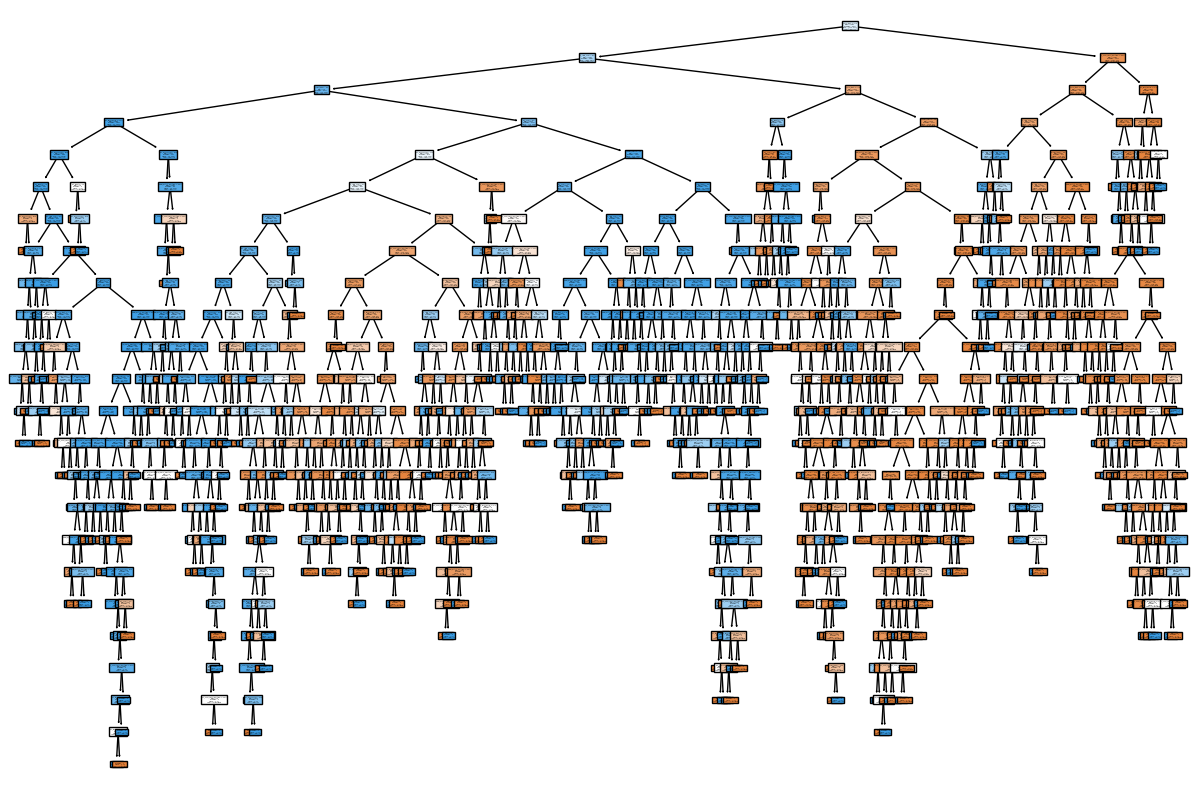

In [10]:


# Visualize the first tree in Random Forest
tree_to_visualize = rf_model.estimators_[0]

plt.figure(figsize=(15, 10))
plot_tree(tree_to_visualize, feature_names=sess_train_df.columns, class_names=['No Warning', 'Warning'], filled=True)
plt.show()

In [11]:
def evaluate_classifier(classifier, X_test, y_test, classifier_name):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    print(f"{classifier_name} Metrics:")
    print(f"Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}")
    print()

# Assuming dt_classifier, rf_classifier, X_test, and y_test are defined

# Evaluate Decision Tree
evaluate_classifier(dt_classifier, sess_train_df_copy,sess_train_df_out, "Decision Tree")

# Evaluate RandomForest
evaluate_classifier(rf_classifier, sess_train_df_copy,sess_train_df_out, "Random Forest")

Decision Tree Metrics:
Accuracy: 1.00000, Precision: 1.00000, Recall: 1.00000

Random Forest Metrics:
Accuracy: 1.00000, Precision: 1.00000, Recall: 1.00000



### Zhodnotenie

## Optimializácia alias hyperparameter tuning

- V tejto časti sa najskôr detailnejšie pozrieme na jeden z našich vybraných stromových algoritmov z predchádzajúcej časti, kokrétne na __RandomForestClassifier__ z knižnice __scikit__. Rozhodovacie stromy vyžadujú dataset, na ktorom sa učia rozhodovať, konkrétne __klasifikovať__ pri kategoriách alebo vykonať regresiu pri __numerických hodnotách__.
- __DecisionTreeClassifier__ je schopný klasifikovať dataset do niekoľkých tried, avšak použitie jeho samotného je náchylné na __overfitting__. Zato __RandomForesClassifer__ obsahuje viacero takýcho rozhodovacích stromov, čo rapídne redukuje možnosť overfittingu. Okrem toho, vďaka viacerým stromom sa zvyšuje aj celková __presnosť klasifikácie__. V neposlednom rade poskytuje  aj spoľahlivejší odhad __dôležitosti jednotlivých vstupných atribútov__.

    a) __n_estimators__ - počet zahrnutých stromov

    b) __criterion__ - funkcia na meranie kvality rozdelenia

    b) __max_features__ - maximálny počet vstupných atribútov

    c) __max_depth__ - maximálna hĺbka v strome

    d) __min_sample_split__ - minimálny počet vo vzorke na rozdelenie uzla

    e) __min_sample_leaf__ - minimálny počet vo vzorke na to, aby uzol mohol byť listom

    ...

#### Referencie

[RandomForest vs DecisionTree web stránka](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/)

[DecisionTreeClassifier - scikit web stránka](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    

- Teraz budeme skúšať rôzne hodnoty nami zvolených hyperparametrov (__tuning__) na RandomForestClassifier algoritme. Tuning budeme vykonávať na cieľovom atribúte _ack_ na vstupných nasledovných atribútoch:

    a) *pct_input*
    
    b) *mouse_move_total_rel_distance*

    c) *pct_scroll_move_duration*
- Kombinácie modelov (__ensemble__) budeme realizovať pomocou __3 vzoriek__, čiže __base modelov__ z nášho trénovacieho modelu, pričom každá vzorka bude obsahovať __1000 náhodných riadkov__.
- Nasledovná funkcia využíva __RandomForestClassifier__ a testuje ho na rôznych __vzorkách__ (rôznych basemodeloch, parameter *num_samples*), pričom takisto dostáva ako parameter aj nejaký tuning hyperparametrov spomínaného algoritmu. Funkcia využíva triedu __GridSearchCV__ na vyskúšanie všetkých parametrov a určenie tých najvhodnejších. Tie sa určia podľa hodnoty špecifkovanej metriky (v tomto prípade __accurracy__).

In [12]:

features = ['pct_input', 'mouse_move_total_rel_distance', 'pct_scroll_move_duration']
target_col = 'ack'

def perform_tests(df: pd.DataFrame, feature_cols: List[str], target_col: str, param_grid: Dict[str, List], train_df: float = 0.8, num_samples: int = 3, samples: int = 1000, metric: Literal['accuracy', 'precision', 'recall'] = 'accuracy'):
    
    #firstly, the provided dataframe is split into training and testing dataset according to the specified proportion
    train_df, test_df = split_data(df, proportion=train_df)

    #now, a specific amount of samples are tested
    for i in range(num_samples):
        # feature atttributes and target are sampled consistently
        sampled_data = train_df[feature_cols + [target_col]].sample(samples, random_state=42 + i)  # Adjust the random_state
        features = sampled_data.drop(target_col, axis=1)
        target = sampled_data[target_col]

        # converting numerical features to categories
        for col in features.columns:
            num_to_category(df=features, col=col)

        # initializing and configuring the classifier
        rf_classifier = RandomForestClassifier(random_state=42)

        # performing grid search
        grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=metric)
        grid_search.fit(features, target)

        # getting best hyperparameters
        best_params = grid_search.best_params_
        print(f"\nSample {i + 1} - Best Hyperparameters:", best_params)

        # getting best model
        best_model = grid_search.best_estimator_

        # predicting on the training set
        y_pred_train = best_model.predict(features)

        # evaluating training accuracy
        train_accuracy = accuracy_score(target, y_pred_train)
        print(f"Sample {i + 1} - Training Accuracy:", train_accuracy)

        # doing the same for the testing dataset
        sampled_test_data = test_df[feature_cols + [target_col]].sample(samples, random_state=42 + i)
        test_features = sampled_test_data.drop(target_col, axis=1)
        test_target = sampled_test_data[target_col]

        for col in test_features.columns:
            num_to_category(df=test_features, col=col)

        y_pred_test = best_model.predict(test_features)

        test_accuracy = accuracy_score(test_target, y_pred_test)
        print(f"Sample {i + 1} - Test Accuracy:", test_accuracy)


- Najskôr si vytvoríme tzv. *param_grid*, ktorá bude obsahovať rôzne konfigurácie hyperparametrov. Najskôr špecifikujeme nízke hodnoty pri parametroch, ktoré sú menej náročné na __výkon__, zato majú negatívny vplyv na __celkovú presnosť__ klasifikácie. Sú tu najmä parametre __n_estimators__ a __max_depth__.

In [13]:
param_grid = {
    'n_estimators': [1, 3, 5],
    'max_depth': [2, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [10, 'sqrt', 'log2']
}

perform_tests(df=sess_df, feature_cols=features, target_col=target_col, param_grid=param_grid, num_samples=3, samples=1000, metric='accuracy')


Sample 1 - Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 5}
Sample 1 - Training Accuracy: 0.793
Sample 1 - Test Accuracy: 0.788

Sample 2 - Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1}
Sample 2 - Training Accuracy: 0.798
Sample 2 - Test Accuracy: 0.755

Sample 3 - Best Hyperparameters: {'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 3}
Sample 3 - Training Accuracy: 0.822
Sample 3 - Test Accuracy: 0.782


- Tento test sa na našom zariadení vykonával niečo nad __30 sekúnd__. Vykonali sme celkovo 3 vzorky a vidno, že presnosť trénovacieho datasetu je pri všetkych hodnotách zhruba rovnaká. Pri testovaní modelu na testovacom datasete, boli hodnoty tiež zhruba rovnaké. Možno teda prehlásiť, že model je __robustný__ a nie je náchylný na __overfitting__. Teraz môžme zvýšiť naše požiadavky na výkon a na presnosť. Nasledovný test by mal trvať dlhšie, zato výsledky by mali byť ešte lepšie.

In [14]:
param_grid = {
    'n_estimators': [5, 7, 10],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [10, 'sqrt', 'log2']
}

perform_tests(df=sess_df, feature_cols=features, target_col=target_col, param_grid=param_grid, num_samples=3, samples=1000, metric='accuracy')


Sample 1 - Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
Sample 1 - Training Accuracy: 0.801
Sample 1 - Test Accuracy: 0.77

Sample 2 - Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 7}
Sample 2 - Training Accuracy: 0.817
Sample 2 - Test Accuracy: 0.774

Sample 3 - Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}
Sample 3 - Training Accuracy: 0.824
Sample 3 - Test Accuracy: 0.792


- Test dopadol, ako sme očakávali. __Čas vykonávania__ bol takmer __60 sekúnd__, zato vidíme, že presnosť nášho modelu bola na trénovacích vzorkách až o __10 percent__ vyššia, ako tomu bolo pri predchádzajúcom teste. Avšak keď sme model testovali na testovacích dátach, výsledky boli ešte nižšie, ako tomu boli pri predhádzajúcom teste. Takže __overfitting__ tohto modelu je vyšší ako prvom modeli.

In [17]:
from sklearn.model_selection import cross_val_score

X = sess_train_df_copy #Feature
y = sess_train_df_out #Target

# Cross-validation for Decision Tree DT
dt_cv_scores = cross_val_score(dt_classifier, X, y, cv=5, scoring='accuracy')
print(f"Decision Tree Cross-Validation Scores: {dt_cv_scores}")
print(f"Mean Accuracy: {dt_cv_scores.mean():.5f}")

# Cross-validation for Random Forest RF
rf_cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
print(f"Random Forest Cross-Validation Scores: {rf_cv_scores}")
print(f"Mean Accuracy: {rf_cv_scores.mean():.5f}")

Decision Tree Cross-Validation Scores: [0.89657143 0.90628571 0.88914286 0.87535735 0.89193825]
Mean Accuracy: 0.89186
Random Forest Cross-Validation Scores: [0.948      0.948      0.936      0.93539165 0.94968553]
Mean Accuracy: 0.94342


## Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### Stratégie riešenia chýbajúcich hodnôt a outlierov

- Chýbajúce hodnoty bolo nutné nejakým spôsobom odstrániť, či nahradiť, inak by sme nemohli jednotlivé numerické stĺpce rozdeliť do kategórií. V našej pôvodnej analýze bol počet nešpecifikovaných hodnôt príliš veľký, aby sme si ich mohli dovoliť odstrániť, preto sme ich nahradzovali __najčastejšou hodnotou__. Teraz uskutočníme test, kde všetky takéto hodnoty odstránime a porovnáme výsledky.
- Pre porovnávanie rozdielu medzi výsledkami (rules alebo accurracies) pri rôznych metrikách budeme používať funkciu *compare(rules_1, rules_2)*, ktorá dostane na vstupe dve pravidlá alebo accuracies a vráti rozdiel medzi *rules_2* a *rules_1*. Teda pri bežných pravidlách bude tento rozdiel buď 0 (žiadny rozdiel, rovnaké rozhodnutie pre kúpu alebo nekúpu) alebo 1 a pri accurracies bude buď záporný, ak presnosť klesne, nulový, ak sa nezmení alebo kladný, ak presnosť narastie.

In [ ]:
def compare(rules: Dict[str, int], rules_2: Dict[str, int]):
    if len(rules) != len(rules_2):
        raise ValueError("Rule sets must contain same amount of rules for successful comparison!")
    
    differences = {}

    for rule in rules:
        differences[rule] = rules_2[rule] - rules[rule]
    
    return differences

def process_and_compare(df1: pd.DataFrame, predictors: List[str], bins: int = None, rules_a = None, rules_p = None, rules_r = None, accuracies = None, precisions = None, recalls = None):

    for predictor in predictors:
        if predictor == 'browser_name':
            continue
        elif predictor == 'session_start':
            timestamp_to_category(df1, col=predictor)
        else:
            num_to_category(df1, col=predictor, num_bins=bins)

    freq_tables = frequency_tables(df=df1, target_column='ack', predictors=predictors)

    rules_a_2, accuracies_2, metric = one_rule_alg(freq_tables=freq_tables, metric='accuracy')
    rules_p_2, precisions_2, metric_2 = one_rule_alg(freq_tables=freq_tables, metric='precision')
    rules_r_2, recalls_2, metric_3 = one_rule_alg(freq_tables=freq_tables, metric='recall')

    if rules_a:
        print(f"{metric}, {compare(rules=rules_a, rules_2=rules_a_2)}")

    if rules_p:
        print(f"{metric_2}, {compare(rules=rules_p, rules_2=rules_p_2)}")
    
    if rules_r:
        print(f"{metric_3}, {compare(rules=rules_r, rules_2=rules_r_2)}")
        
    print("")

    if accuracies:
        print(f"{metric}, {compare(rules=accuracies, rules_2=accuracies_2)}")
    if precisions:
        print(f"{metric_2}, {compare(rules=precisions, rules_2=precisions_2)}")
    if recalls:
        print(f"{metric_3}, {compare(rules=recalls, rules_2=recalls_2)}")

- Budeme teda porovnávať pravidlá a hodnoty accuraccies namerané v časti __Rozhodnutie na základe viac atribútov__ najskôr s variantom, v ktorom odstránime všetky riadky s __chýbajúcimi hodnotami__ a potom s variantom, kde neodstránime __vychýlené hodnoty__.

In [ ]:
sess_train_df_copy = sess_df.copy()


# Here we are dropping al NaN values
for col in sess_train_df_copy.columns:
    sess_train_df_copy.dropna(subset=[col], inplace=True)

process_outliers(sess_train_df_copy)

process_and_compare(df1=sess_train_df_copy, rules_a=rules_a, rules_p=rules_p, rules_r=rules_r,
                    accuracies=accuracies, precisions=precisions, recalls=recalls, predictors=predictors)



{'used_metric': 'accuracy'}, {'browser_name': 0.0, 'pct_input': 0.0, 'wild_mouse_duration': 0.0, 'pct_scroll_move_duration': 0.0, 'pct_wild_mouse': 0.0, 'session_start': 0.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 0.0, 'pct_click': 0.0, 'page_activity_duration': 0.0, 'pct_scrandom': 0.0, 'mouse_move_total_rel_distance': 0.0, 'pct_click_product_info': 0.0, 'scroll_move_total_rel_distance': 0.0, 'pct_mouse_click': 0.0, 'session_duration': 0.0, 'total_load_time': 0.0}
{'used_metric': 'precision'}, {'browser_name': 0.0, 'pct_input': 0.0, 'wild_mouse_duration': 0.0, 'pct_scroll_move_duration': 0.0, 'pct_wild_mouse': 0.0, 'session_start': 0.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 0.0, 'pct_click': 0.0, 'page_activity_duration': 0.0, 'pct_scrandom': 0.0, 'mouse_move_total_rel_distance': 0.0, 'pct_click_product_info': 0.0, 'scroll_move_total_rel_distance': 0.0, 'pct_mouse_click': 0.0, 'session_duration': 0.0, 'total_load_time': 0.0}
{'used_metric': 'recall'}, {'browser_name': 0.0, 'pct

- Z výsledkov vidno, že vylúčenie všetkých NaN hodnôt nespôsobilo nejaký rozdiel v rozhodovaniach. Avšak v presnostiach isté rozdiely možno vidieť, i keď veľmi malé. Teraz môžme porovnať dané hodnoty s tými, pri ktorých by sme sa rozhodli neodstrániť outliery.

In [ ]:
sess_train_df_copy = sess_df.copy()

#Here we process the NaNs as we did before but we omit the outliers
process_missing_vals(sess_train_df_copy)

process_and_compare(df1=sess_train_df_copy, rules_a=rules_a, rules_p=rules_p, rules_r=rules_r,
                    accuracies=accuracies, precisions=precisions, recalls=recalls, predictors=predictors)

{'used_metric': 'accuracy'}, {'browser_name': 0.0, 'pct_input': 0.0, 'wild_mouse_duration': 0.0, 'pct_scroll_move_duration': 0.0, 'pct_wild_mouse': 0.0, 'session_start': 0.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 0.0, 'pct_click': 0.0, 'page_activity_duration': 0.0, 'pct_scrandom': 0.0, 'mouse_move_total_rel_distance': 0.0, 'pct_click_product_info': 0.0, 'scroll_move_total_rel_distance': 0.0, 'pct_mouse_click': 0.0, 'session_duration': 0.0, 'total_load_time': 0.0}
{'used_metric': 'precision'}, {'browser_name': 0.0, 'pct_input': 0.0, 'wild_mouse_duration': 0.0, 'pct_scroll_move_duration': 0.0, 'pct_wild_mouse': 0.0, 'session_start': 0.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 0.0, 'pct_click': 0.0, 'page_activity_duration': 0.0, 'pct_scrandom': 0.0, 'mouse_move_total_rel_distance': 0.0, 'pct_click_product_info': 0.0, 'scroll_move_total_rel_distance': 0.0, 'pct_mouse_click': 0.0, 'session_duration': 0.0, 'total_load_time': 0.0}
{'used_metric': 'recall'}, {'browser_name': 0.0, 'pct

- Opäť možno vidieť, že neodstránenie vychýlených hodnôt nemá veľký vplyv na rozhodovanie ani na presnosti. Je zrejmé, že dataset __sessions.csv__ neobsahuje také množstvo chýbajúcich alebo vychýlených hodnôt, aby to malo razantný vplyv na rozhodovanie nášho OneR algoritmu.

### Stratégie scaling a transformers

- Teraz preskúmame techniky __scaling__ and __transformers__. Na scaling používame funkciu _scale()_, ktorá dostane ako parameter dataset a stĺpce, ktoré chce škálovať či normalizovať. Ak ide o normálne rozdelenie, funkcia stĺpec štandardizuje, inak použije _MinMaxScaler()_, aby ho vyškálovala do intervalu od (0 po 1).

In [ ]:
def scale(df: pd.DataFrame, cols: [str]):
    print("")

    for col in cols:
        if not pd.to_numeric(df[col], errors='coerce').notna().all():
            raise TypeError(f"The column {col} must be entirely numeric!")

        # Decide which normality test to use based on sample size
        if len(df) >= 5000:
            _, p_value = kstest(df[col], 'norm')
        else:
            _, p_value = shapiro(df[col])

        if p_value > 0.05:
            print(f"Col: {col} is normally distributed! Applying StandardScaler...")
            std_scaler = StandardScaler()
            df[col] = std_scaler.fit_transform(df[[col]])
        else:
            print(f"Col: {col} is not normally distributed! Applying MinMaxScaler...")
            min_max_scaler = MinMaxScaler()
            df[col] = min_max_scaler.fit_transform(df[[col]])

    print("")


In [ ]:
columns_to_scale = ['pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance',
              'pct_click_product_info', 'scroll_move_total_rel_distance', 'pct_mouse_click', 'session_duration', 'total_load_time']


sess_train_df_copy = sess_train_df.copy()
scale(sess_train_df_copy, cols=columns_to_scale)


process_and_compare(df1=sess_train_df_copy, rules_a=rules_a, rules_p=rules_p, rules_r=rules_r,
                  accuracies=accuracies, precisions=precisions, recalls=recalls, predictors=predictors, bins=10)


Col: pct_input is not normally distributed! Applying MinMaxScaler...
Col: wild_mouse_duration is not normally distributed! Applying MinMaxScaler...
Col: pct_scroll_move_duration is not normally distributed! Applying MinMaxScaler...
Col: pct_wild_mouse is not normally distributed! Applying MinMaxScaler...
Col: pct_doubleclick is not normally distributed! Applying MinMaxScaler...
Col: pct_rage_click is not normally distributed! Applying MinMaxScaler...
Col: pct_click is not normally distributed! Applying MinMaxScaler...
Col: page_activity_duration is not normally distributed! Applying MinMaxScaler...
Col: pct_scrandom is not normally distributed! Applying MinMaxScaler...
Col: mouse_move_total_rel_distance is not normally distributed! Applying MinMaxScaler...
Col: pct_click_product_info is not normally distributed! Applying MinMaxScaler...
Col: scroll_move_total_rel_distance is not normally distributed! Applying MinMaxScaler...
Col: pct_mouse_click is not normally distributed! Applying M

{'used_metric': 'accuracy'}, {'browser_name': 0.0, 'pct_input': 0.0, 'wild_mouse_duration': 0.0, 'pct_scroll_move_duration': 0.0, 'pct_wild_mouse': 1.0, 'session_start': 0.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 0.0, 'pct_click': 0.0, 'page_activity_duration': 1.0, 'pct_scrandom': 0.0, 'mouse_move_total_rel_distance': 1.0, 'pct_click_product_info': 1.0, 'scroll_move_total_rel_distance': 0.0, 'pct_mouse_click': 0.0, 'session_duration': 0.0, 'total_load_time': 0.0}
{'used_metric': 'precision'}, {'browser_name': 0.0, 'pct_input': 0.0, 'wild_mouse_duration': 0.0, 'pct_scroll_move_duration': 0.0, 'pct_wild_mouse': 1.0, 'session_start': 0.0, 'pct_doubleclick': 0.0, 'pct_rage_click': 0.0, 'pct_click': 0.0, 'page_activity_duration': 1.0, 'pct_scrandom': 0.0, 'mouse_move_total_rel_distance': 1.0, 'pct_click_product_info': 1.0, 'scroll_move_total_rel_distance': 0.0, 'pct_mouse_click': 0.0, 'session_duration': 0.0, 'total_load_time': 0.0}
{'used_metric': 'recall'}, {'browser_name': 0.0, 'pct

- Tentokrát dochádzalo aj k zmenám v rozhodovaní, napríklad pri *pct_wild_mouse* či *pct_activity_duration*. Aj zmeny v presnostiach boli výraznejšie, napríklad *session_duration* to klesla hodnota presnosti pri metrike __Recall__ až o __22 percent__.

In [ ]:
columns_to_scale = ['pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_wild_mouse',
              'pct_doubleclick', 'pct_rage_click', 'pct_click', 'page_activity_duration', 'pct_scrandom', 'mouse_move_total_rel_distance',
              'pct_click_product_info', 'scroll_move_total_rel_distance', 'pct_mouse_click', 'session_duration', 'total_load_time']


sess_train_df_copy = sess_train_df.copy()

transform(sess_train_df_copy, cols=columns_to_scale)
print("")

for col in columns_to_scale:
    if is_gaussian(df=sess_train_df_copy, col=col):
        print(f"Col: {col} was transformed into Gaussian!")
    
print("")


process_and_compare(df1=sess_train_df_copy, rules_a=rules_a, rules_p=rules_p, rules_r=rules_r,
                  accuracies=accuracies, precisions=precisions, recalls=recalls, predictors=predictors)



Col: pct_input is not normally distributed! Transforming...
Col: wild_mouse_duration is not normally distributed! Transforming...
Col: pct_scroll_move_duration is not normally distributed! Transforming...
Col: pct_wild_mouse is not normally distributed! Transforming...
Col: pct_doubleclick is not normally distributed! Transforming...
Col: pct_rage_click is not normally distributed! Transforming...
Col: pct_click is not normally distributed! Transforming...
Col: page_activity_duration is not normally distributed! Transforming...
Col: pct_scrandom is not normally distributed! Transforming...
Col: mouse_move_total_rel_distance is not normally distributed! Transforming...
Col: pct_click_product_info is not normally distributed! Transforming...
Col: scroll_move_total_rel_distance is not normally distributed! Transforming...
Col: pct_mouse_click is not normally distributed! Transforming...
Col: session_duration is not normally distributed! Transforming...
Col: total_load_time is not normally

- Naša funkcia _transform()_ využíva triedu __PowerTransformer__ a __Yeo-Johnsonovu metódu__ na to, aby transformovala rozdelenie na normálne, avšak nie vždy sa to podarí. Druhý zoznam ukazuje, pri ktorých atribútoch sa to podarilo. Z výsledkov vidno, že množina atribútov, pri ktorých došlo k zmene klasifikácie je podmnožinou tohto zoznamu.

## Výber atribútov a výber algoritmov strojového učenia, či majú vplyv na výkonnosť (presnosť a run-time)

- Áno, výber atribútov a algoritmov strojového učenia mali výrazny vplyv na výkonnosť modelov. Pri niektorých atribútoch viedlo vylúčenie irelevantných informácií zvýšeniu presnosti predikcií modleu. Naopak, pri iných atribútoch zachovanie väčšiny prvkov viedlo k výraznému zlepšeniu presnosti modelu. Tieto výsledky sme nahali v jupyter notebook.